In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import necessary libraries.

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from PIL import Image
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

Unzip the dataset stored in your Google Drive.

In [ ]:
!unzip /content/drive/MyDrive/Projects/archive.zip

Archive:  /content/drive/MyDrive/Projects/archive.zip
replace archive/auto_test/0/9003175_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Define paths for training, testing, and validation datasets.

list_of_classes contains the class labels for the dataset.

In [ ]:
train_path = '/content/archive/train'
test_path = '/content/archive/test'
valid_path = '/content/archive/val'
list_of_classes=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

We have three datasets for training,testing and validation. Finding length of each dataset.Organizing the file paths and labels into DataFrames, enabling efficient data loading and preprocessing for training and evaluation.

train_df lenght:  5778   test_df length:  1656   valid_df length:  826
The number of classes in the dataset is:  5
            CLASS               IMAGE COUNT 
           Doubtful                1046     
           Healthy                 2286     
           Minimal                 1516     
           Moderate                 757     
            Severe                  173     


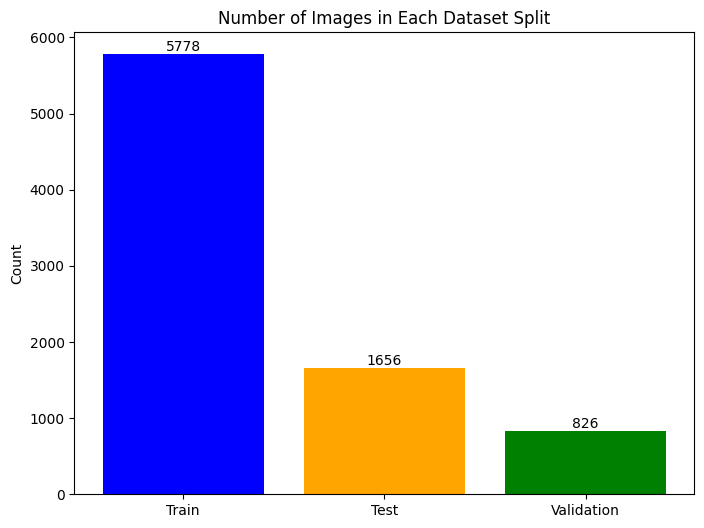

Healthy  has the most images=  2286   Severe  has the least images=  173


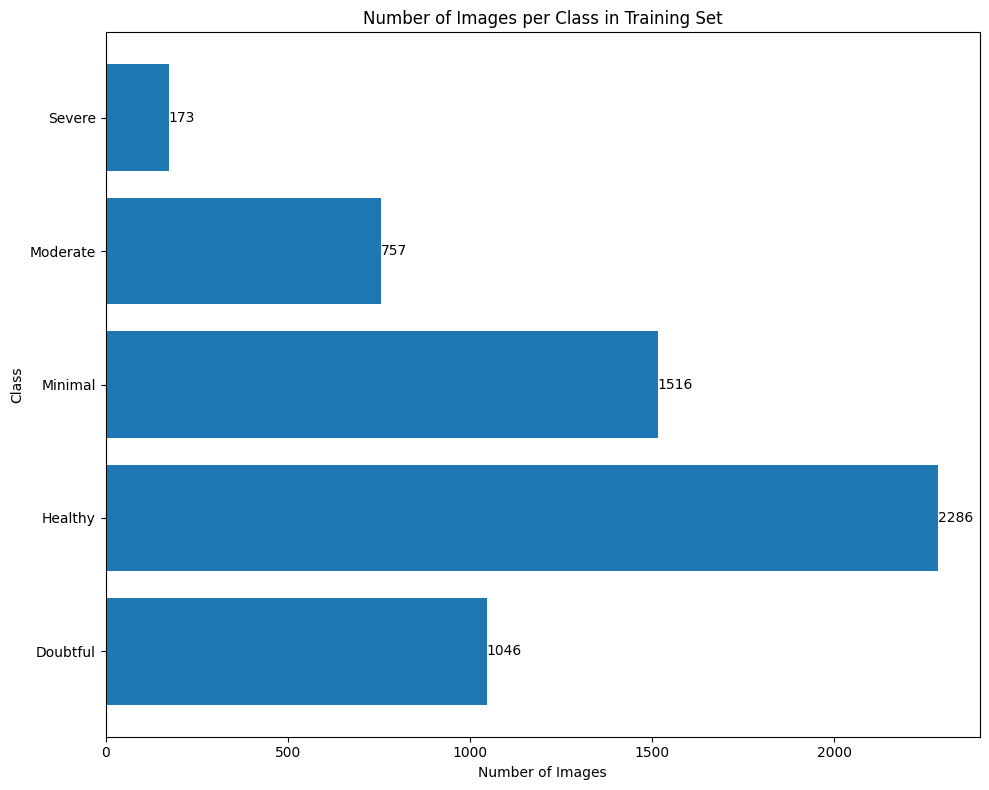

average height=  224  average width=  224 aspect ratio=  1.0


In [ ]:
 for d in [train_path, test_path, valid_path]:
    filepaths = []
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        intklass=int(klass)
        label=list_of_classes[intklass]
        classpath=os.path.join(d, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(label)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    pdf=pd.concat([Fseries, Lseries], axis=1)
    if d == test_path:
        test_df=pdf
    elif d == valid_path:
        valid_df=pdf
    else:
        train_df=pdf
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))



# Visualization for dataset splits
plt.figure(figsize=(8, 6))
split_labels = ['Train', 'Test', 'Validation']
split_counts = [len(train_df), len(test_df), len(valid_df)]
plt.bar(split_labels, split_counts, color=['blue', 'orange', 'green'])
plt.title('Number of Images in Each Dataset Split')
plt.ylabel('Count')
for i, count in enumerate(split_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')
plt.show()


# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)

# Visualization for class distribution in training set
plt.figure(figsize=(10, 8))
plt.barh(classlist, countlist)
plt.title('Number of Images per Class in Training Set')
plt.xlabel('Number of Images')
plt.ylabel('Class')
for i, count in enumerate(countlist):
    plt.text(count, i, str(count), va='center')
plt.tight_layout()
plt.show()

# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

The first visualisation show the distribution of images in each dataset split.
The second visualisation shows the distribution of images per class in training dataset.

It is found that training, testing, and validation sets, have 5778, 1656, and 826 images respectively.

The dataset is imbalanced, with the Healthy class having the most images (2286) and the Severe class having the fewest (173), which may bias the model toward the majority class.

 The images have an average height and width of 224pixels with an aspect ratio of 1.0, indicating they are square and suitable for deep learning models requiring fixed input sizes.


As we found that the dataset is imbalanced we are reducing it by limiting the number of samples per class to a specified maximum (max_samples) while ensuring no class falls below a minimum threshold (min_samples).

By setting max_samples=500, the function ensures no class exceeds 500 samples, addressing class imbalance and preventing overrepresentation of majority classes like Healthy.

With min_samples=173, the function retains all samples for minority classes (e.g., Severe), ensuring they are not underrepresented in the trimmed dataset.

We are using random sampling (random_state=123) to maintain fairness and reproducibility when reducing class sizes.

Overall, this step of trimming helps create a more balanced dataset, reducing bias and improving the model's ability to generalize across all classes.

In [ ]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique():
        group=groups.get_group(label)
        count=len(group)
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=173
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  173


**Data Augmentation:** The balance function uses techniques like horizontal flipping, rotation, and zooming to generate synthetic images, increasing dataset diversity and addressing class imbalance.

**Target Class Size:** By setting n=500, the function ensures each class reaches 500 samples, boosting minority classes (e.g., Severe) to match the target size.

**Augmentation Process:** For classes with fewer than 500 samples, the function creates additional images (delta = n - sample_count) and saves them in a dedicated directory (aug_dir).

**Dataset Expansion:** The function merges the original dataset with the augmented images, increasing the total dataset size from 2173 to 2500 samples.

**Improved Model Generalization:** Augmentation enhances the dataset's variability, helping the model generalize better and reducing overfitting to minority or majority classes.

In [ ]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df['labels'].unique():
        dir_path=os.path.join(aug_dir,label)
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False,
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)
        flist=os.listdir(classpath)
        for f in flist:
          fpath=os.path.join(classpath,f)
          aug_fpaths.append(fpath)
          aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df

n=500 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(224,224) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  2173
Found 173 validated image filenames.
Total Augmented images created=  327
Length of augmented dataframe is now  2500


We are combining the classes Healthy, Doubtful, and Minimal into a single class labeled Healthy, simplifying the classification task and reducing complexity.

After relabeling, the dataset now has three classes: Healthy (1500 samples), Moderate (500 samples), and Severe (500 samples), balancing the dataset for better model training.

Hence, Consolidating classes reduces the number of target categories, making the model easier to train and improving its ability to distinguish between the remaining classes.

In [ ]:
def relabel(label_in):
    if label_in =='Healthy' or label_in == 'Doubtful' or label_in =='Minimal':
        label='Healthy'
    else:
        label=label_in
    return label


for df in [train_df, test_df, valid_df]:
    for i in range (len(df)):
        label=df['labels'].iloc[i]
        new_label=relabel(label)
        df['labels'].iloc[i]=new_label
print (train_df['labels'].value_counts())

<ipython-input-25-7d682229a53b>:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['labels'].iloc[i]=new_label


labels
Healthy     1500
Moderate     500
Severe       500
Name: count, dtype: int64


We ensure that each class in the dataset has exactly 500 samples, creating a balanced dataset for training and reducing bias toward any particular class.

By setting both max_samples and min_samples to 500, the function guarantees uniformity across all classes, improving the model's ability to generalize and perform equally well on all categories.

after trimming, the maximum samples in any class is now  500  and the minimum samples in any class is  500


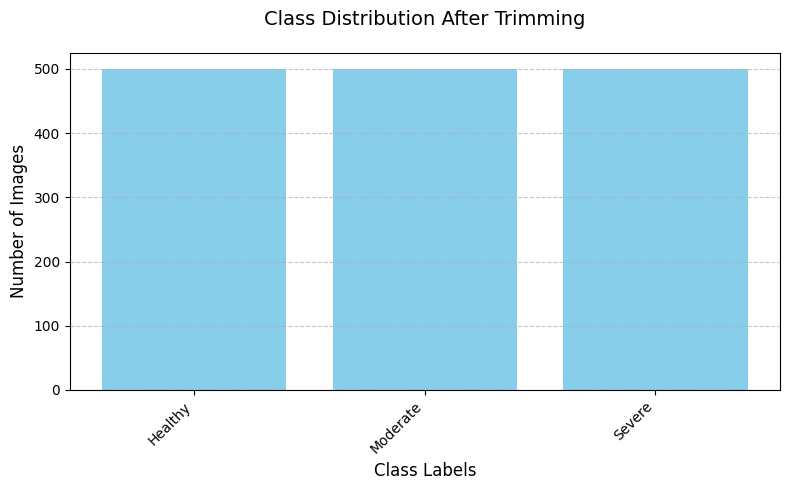

In [ ]:
max_samples=500 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=500
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

# Get class counts after trimming
class_counts = train_df['labels'].value_counts()

plt.figure(figsize=(8, 5))
bars = plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.title('Class Distribution After Trimming', fontsize=14, pad=20)
plt.xlabel('Class Labels', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Finding the number of validated images in each datset(training, testing and validation). We should use only the validated images from training and validation datasets.
The visualisation shows that all the classes have same number of images after trimming.


In [ ]:
batch_size=20
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 1500 validated image filenames belonging to 3 classes.
Found 826 validated image filenames belonging to 3 classes.
Found 1656 validated image filenames belonging to 3 classes.
test batch size:  72   test steps:  23  number of classes :  3


Display sample batch of images from the data generator, along with their corresponding class labels, to provide a visual understanding of the dataset.


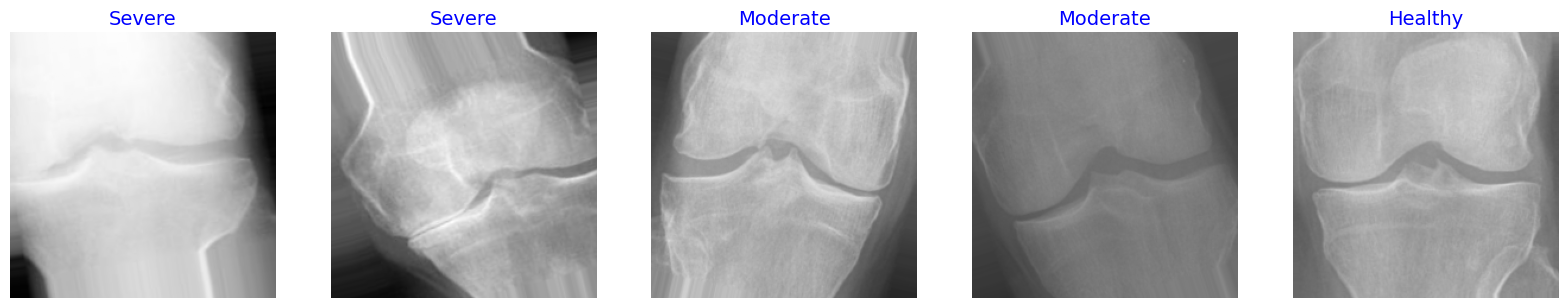

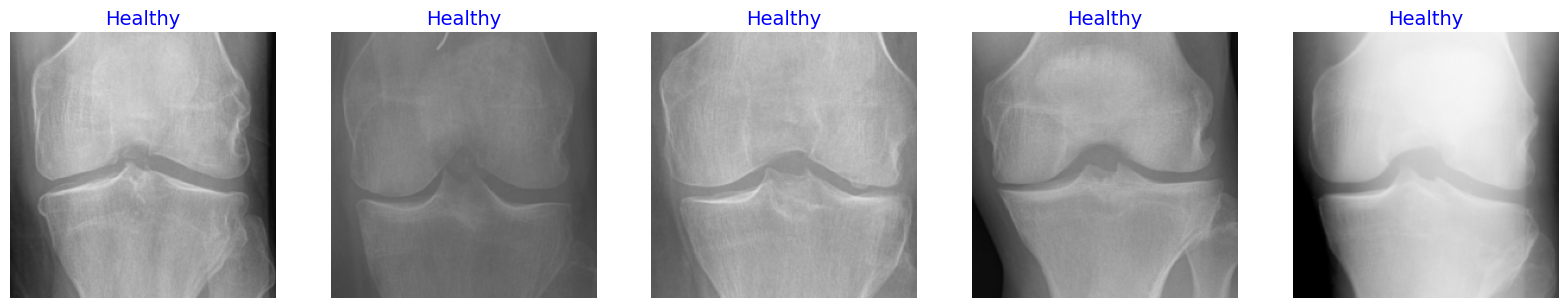

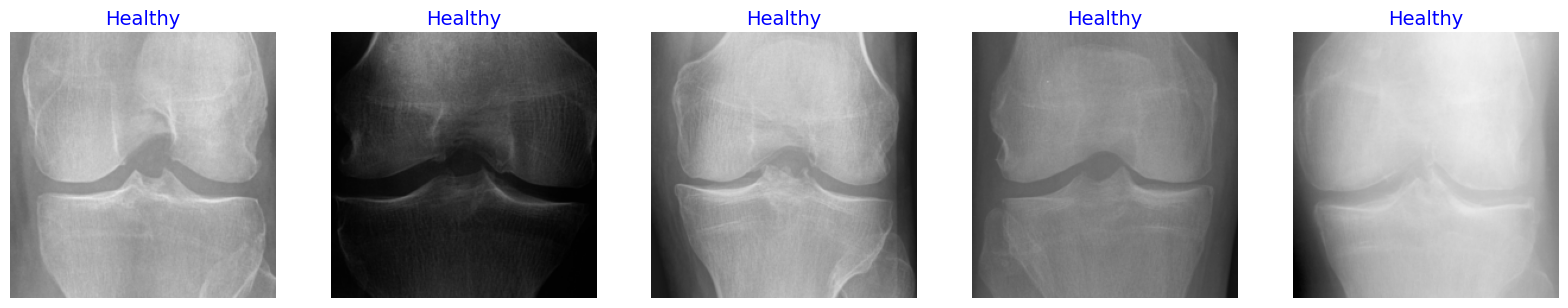

In [ ]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<5:   #show maximum of 25 images
        r=length
    else:
        r=5
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i] /255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen )
show_image_samples(test_gen )
show_image_samples(valid_gen )

#EfficientNetB5

Import necessary libraries.

In [ ]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.utils import plot_model

Resetting the TensorFlow graph to free up memory and remove any previously defined models, ensuring a clean environment for training.

In [ ]:
K.clear_session()
tf.compat.v1.reset_default_graph()

Fine-tuning EfficientNetB5 by adding custom layers and training it for a multi-class classification task with batch normalization, dropout, and regularization to enhance performance and reduce overfitting.

In [ ]:

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB5'
base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

base_model.trainable=True
x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.4, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)

model=Model(inputs=base_model.input, outputs=output)
lr=.001
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

As this is multi label classification, we used categorical crossentropy loss function.
The hyper paramters used are:

*  Learning Rate-0.001 (It controls step size for updates.)
*  Optimizer-Adamax	(It is a variant of Adam and works well with sparse data)
*  Dropout Rate-0.4	(Prevents overfitting)
*  L2 Regularization-0.016	(Penalizes large weights)
*  L1 Regularization-0.006	(Encourages sparsity)
*  Batch Norm Momentum-0.99	(Keeps batch normalization stable)
*  Activation Function-ReLU(Hidden layers) / Softmax (Output layer)


Below is the summary/architecture of the model.

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 86,787,426 (331.07 MB)

 Trainable params: 28,870,195 (110.13 MB)

 Non-trainable params: 176,839 (690.78 KB)

 Optimizer params: 57,740,392 (220.26 MB)

Architecture of the model.

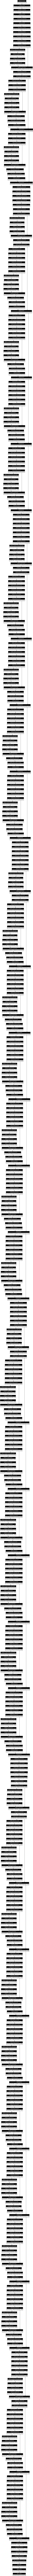

In [ ]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

Adding custom Keras callback that allows the user to dynamically control training by:

*   Monitoring the validation loss and saving the best weights.
*   Asking the user whether to continue training or adjust the learning rate at a specified epoch.
*   Stopping training early if needed.


Defining the clallback class

In [ ]:
class LR_ASK(keras.callbacks.Callback):
  def __init__(self, model, epochs, ask_epoch):
    super(LR_ASK, self).__init__()
    self._model = model
    self.ask_epoch = ask_epoch
    self.epochs = epochs
    self.ask = True  # if True query the user on a specified epoch
    self.lowest_vloss = np.inf
    self.best_weights = self._model.get_weights()  # set best weights to model's initial weights
    self.best_epoch = 1

Handling training start- If ask_epoch is greater than total epochs, no need of user intervention.

In [ ]:
 def on_train_begin(self, logs=None):
    if self.ask_epoch == 0:
      print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
      self.ask_epoch = 1
    if self.ask_epoch >= self.epochs:  # you are running for epochs but ask_epoch>epochs
      print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
      self.ask = False  # do not query the user
    if self.epochs == 1:
      self.ask = False  # running only for 1 epoch so do not query user
    else:
      print('Training will proceed until epoch', ask_epoch, ' then you will be asked to')
      print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')
    self.start_time = time.time()  # set the time at which training started

Handling training end- it loads the best weights after training and also returns the total training time.

In [ ]:
  def on_train_end(self, logs=None):
    print('loading model with weights from epoch ', self.best_epoch)
    self._model.set_weights(self.best_weights)  # set the weights of the model to the best weights
    tr_duration = time.time() - self.start_time  # determine how long the training cycle lasted
    hours = tr_duration // 3600
    minutes = (tr_duration - (hours * 3600)) // 60
    seconds = tr_duration - ((hours * 3600) + (minutes * 60))
    msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
    print(msg, flush=True)  # print out training duration time

Saves the best model weights if the current epoch has a lower validation loss.

In [ ]:
    def on_epoch_end(self, epoch, logs=None):
      v_loss = logs.get('val_loss')  # get the validation loss for this epoch
      if v_loss < self.lowest_vloss:
        self.lowest_vloss = v_loss
        self.best_weights = self._model.get_weights()  # set best weights to model's initial weights
        self.best_epoch = epoch + 1
        print(f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
      else:
        print(f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')


Asking user for input and allowing learning rate adjustment.

In [ ]:

      if self.ask:  # are the conditions right to query the user?
        if epoch + 1 == self.ask_epoch:  # is this epoch the one for querying the user?
          print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
          ans = input()

          if ans == 'H' or ans == 'h' or ans == '0':
            print('you entered ', ans, ' Training halted on epoch ', epoch + 1, ' due to user input\n', flush=True)
            self._model.stop_training = True  # halt training
          else:  # user wants to continue training
            self.ask_epoch += int(ans)
            if self.ask_epoch > self.epochs:
              print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush=True)
            else:
              print('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
              lr = float(tf.keras.backend.get_value(self._model.optimizer.lr))  # get the current learning rate
              print(f'current LR is  {lr:7.5f}  hit enter to keep this LR or enter a new LR')
              ans = input(' ')
              if ans == '':
                print(f'keeping current LR of {lr:7.5f}')
              else:
                new_lr = float(ans)
                tf.keras.backend.set_value(self._model.optimizer.lr, new_lr)  # set the learning rate in the optimizer
                print('changing LR to ', ans)


In [ ]:
epochs=50
ask_epoch=50
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

In [ ]:
new_history=model.fit(x=train_gen,  epochs=epochs, verbose=1, validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/50
75/75 [==============================] - 143s 762ms/step - loss: 8.4692 - accuracy: 0.5973 - val_loss: 7.4540 - val_accuracy: 0.8499
Epoch 2/50
75/75 [==============================] - 55s 734ms/step - loss: 6.6332 - accuracy: 0.7600 - val_loss: 5.8487 - val_accuracy: 0.8995
Epoch 3/50
75/75 [==============================] - 50s 663ms/step - loss: 5.4003 - accuracy: 0.8260 - val_loss: 5.0750 - val_accuracy: 0.8257
Epoch 4/50
75/75 [==============================] - 50s 663ms/step - loss: 4.4406 - accuracy: 0.8753 - val_loss: 4.0142 - val_accuracy: 0.9104
Epoch 5/50
75/75 [==============================] - 50s 663ms/step - loss: 3.7334 - accuracy: 0.8927 - val_loss: 3.4218 - val_accuracy: 0.8935
Epoch 6/50
75/75 [==============================] - 50s 668ms/step - loss: 3.1972 - accuracy: 0.9073 - val_loss: 2.8953 - val_accuracy: 0.9249
Epoch 7/50
75/75 [==============================] - 50s 664ms/step - loss: 2.7170 - accuracy: 0.9280 - val_loss: 2.5603 - val_accuracy: 0.893

The final training accuracy reached 98.93%, and validation accuracy was 92.49%.
The final loss values were:Training Loss: 0.1440, Validation Loss: 0.3427

Evaluating the performance of a trained model on a given test dataset using a confusion matrix and classification report

In [ ]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=test_gen.labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            errors=errors + 1
            file=test_gen.filenames[i]
        y_pred.append(pred_index)

    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests,y_pred

23/23 [==============================] - 17s 414ms/step
there were 104 errors in 1656 tests for an accuracy of  93.72


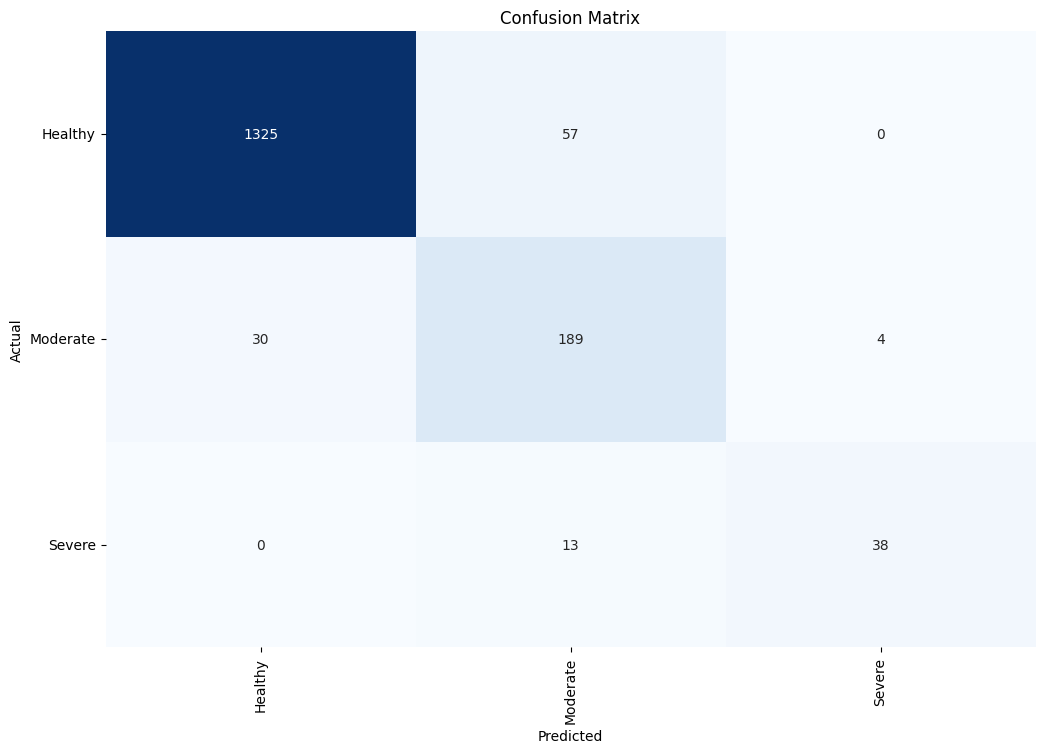

Classification Report:
----------------------
               precision    recall  f1-score   support

     Healthy     0.9779    0.9588    0.9682      1382
    Moderate     0.7297    0.8475    0.7842       223
      Severe     0.9048    0.7451    0.8172        51

    accuracy                         0.9372      1656
   macro avg     0.8708    0.8505    0.8566      1656
weighted avg     0.9422    0.9372    0.9388      1656



In [ ]:
errors, tests,y_pred2=predictor(test_gen, test_steps)


Overall Model Accuracy

*  Accuracy: 93.72% (The model correctly classified 1,552 out of 1,656 samples).
*   Errors: 104 misclassified samples.



Precision
*  The Healthy class has 97.79% precision, meaning most samples predicted as "Healthy" are actually correct.
*  The Moderate class has 72.97% precision.
*  The Severe class has 90.48% precision


Recall
*   The Healthy Class has 95.88% recall, meaning it captures most of "Healthy" classes.
*   The Moderate class has 84.75% recall, meaning it captures a good portion of actual "Moderate" cases but still misses some.
*   The Severe class has 74.51% recall.

F1-Score
*   The Healthy class has an F1 score of 96.82%, indicating a good balance between precision and recall.
*   The Moderate class has an F1-score of 78.42%, indicating a less balance between precision and recall.
*   The Severe class has an F1-score of 81.72%, indicating a fair balance between precision and recall.


Overall Model Performance:

*   Overall, the model performs well with an accuracy of 93.72%.
*   The model performs best on the "Healthy" class with high precision and recall.
*   The "Moderate" class has lower precision (72.97%), meaning some samples classified as "Moderate" might actually belong to other categories.
*   The "Severe" class has the lowest recall (74.51%), suggesting the model struggles to detect all severe cases.























Visualizing loss and accuracy for both training and validation sets over epochs.

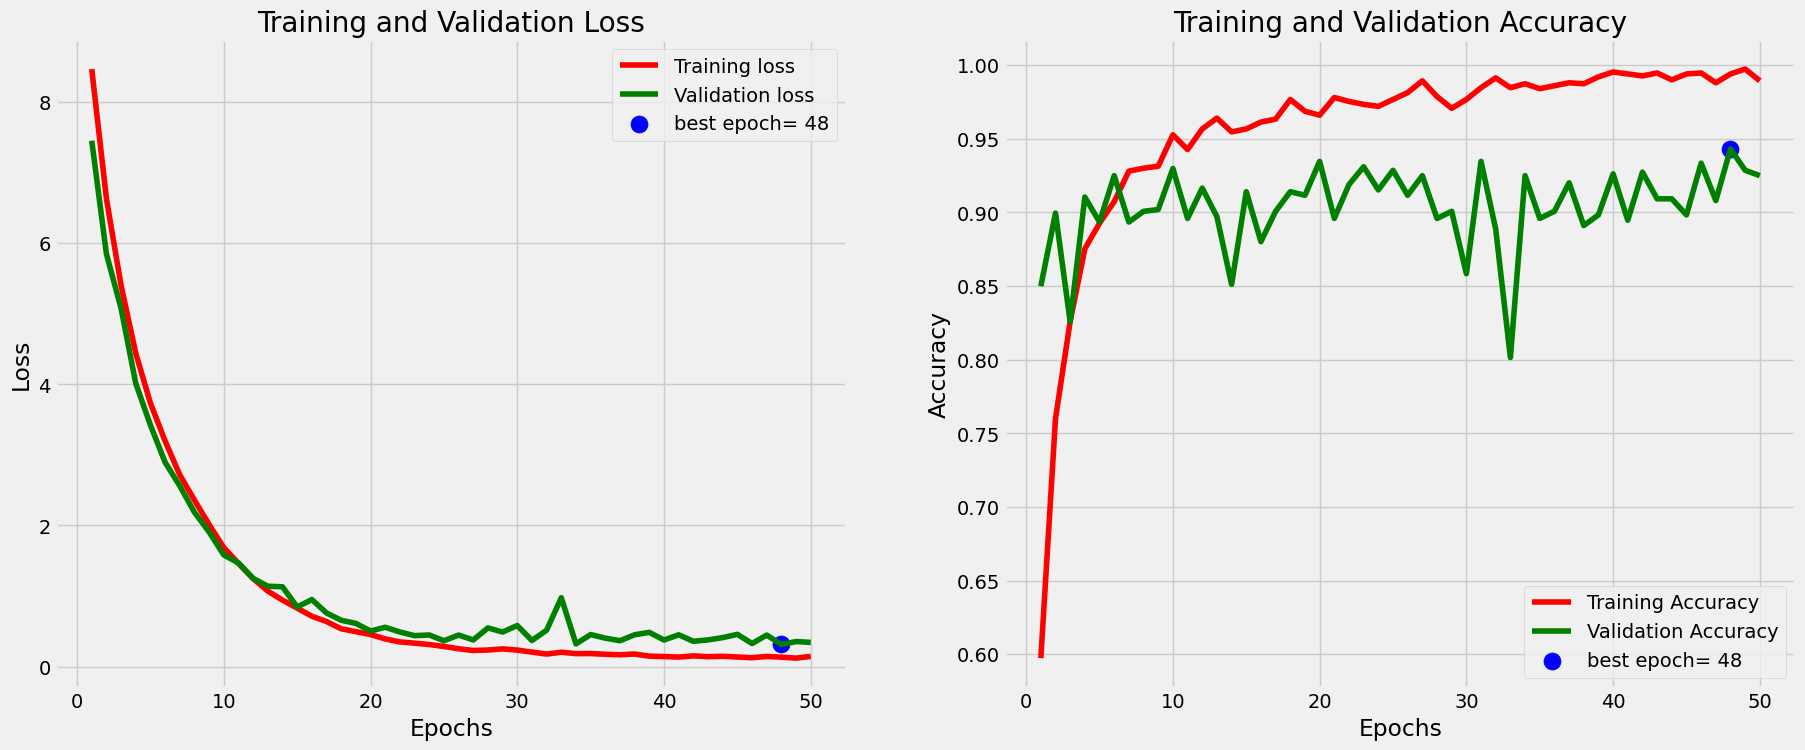

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    plt.show()

tr_plot(new_history,0)

Plot of losses:
*   Both training and validation loss are decreasing over time, indicating that the model is learning effectively.
*   A blue dot marks the epoch with the lowest validation loss (epoch 48), suggesting this epoch might be the best model checkpoint.
*   The validation loss remains close to the training loss, meaning there’s no significant overfitting.

Plot of accuracies:
*   The training accuracy approaches 100%, while validation accuracy stabilizes around 92-94%, showing strong generalization.
*   The blue dot highlights the best epoch based on validation accuracy.
*   There are some fluctuations in validation accuracy, which could indicate natural variability or minor overfitting.






Function to plot the ROC curves and to calculate the Area Under the Curve (AUC).

ROC AUC score: 0.8984262110087573


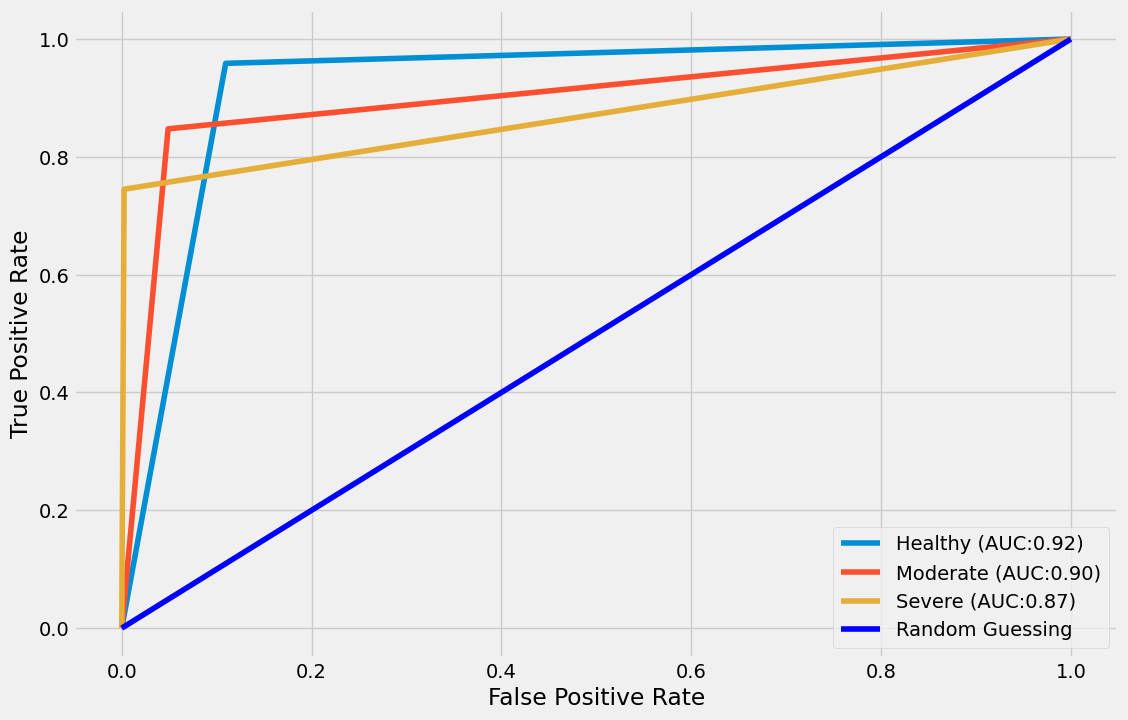

In [ ]:
def roc_cur234():
  target= ['Healthy', 'Moderate', 'Severe']

  # set plot figure size
  fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

  # function for scoring roc auc score for multi-class
  def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
      lb = LabelBinarizer()
      lb.fit(y_test)
      y_test = lb.transform(y_test)
      y_pred = lb.transform(y_pred)

      for (idx, c_label) in enumerate(target):
          fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
          c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
      c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
      return roc_auc_score(y_test, y_pred, average=average)


  print('ROC AUC score:', multiclass_roc_auc_score(test_gen.labels, y_pred2))

  c_ax.legend()
  c_ax.set_xlabel('False Positive Rate')
  c_ax.set_ylabel('True Positive Rate')
  plt.show()
roc_cur234()

The model performs best in detecting "Healthy" cases (AUC 0.92).

Performance slightly declines for "Moderate" and "Severe" cases, possibly due to:
*   More overlapping features in severe cases.
*   Harder-to-detect patterns in advanced conditions.

All models are clinically useful (AUC > 0.8), but the "Healthy" classifier is the most reliable.